## Методические указания по выполнению лабораторной работы №4

**Тема: Сегментация объектов с использованием Mask R-CNN**

**Цель работы:** Познакомиться с архитектурой Mask R-CNN и научиться выполнять сегментацию объектов на изображениях.

**Задачи:**

- Изучить теоретические основы instance segmentation.
- Ознакомиться с архитектурой Mask R-CNN.
- Провести инференс предобученной модели на выбранных изображениях.
- Визуализировать результаты: bounding boxes, маски объектов.
- Рассчитать метрики оценки качества масок.
- Проанализировать ошибки сегментации.
- Провести исследование зависимости качества от параметров confidence score и mask threshold.

### 1. Теоретическая часть

В данной лабораторной работе мы познакомимся с задачей детекции на примере архитектуры [Mask R-CNN](https://arxiv.org/pdf/1703.06870), обученной на наборе данных [COCO](https://cocodataset.org/#home), а также с новой задачей компьютерного зрения - сегментацией. 

**Перед тем, как приступать к выполнению практической части, ознакомьтесь с первоисточниками используемых компонентов, а также документацией по [ссылке](https://pytorch.org/vision/main/models/mask_rcnn.html), включающей подробности работы с моделью и новым форматом данных, сэмплы кода.**

#### 1.1 Instance Segmentation и архитектура Mask R-CNN

Instance segmentation — это задача, в которой необходимо не только обнаружить объект и его класс, но и сегментировать его границы на уровне пикселей. Это усложнённая версия задачи детекции, так как bounding box не всегда точно соответствует форме объекта.

В отличие от semantic segmentation, где модель выдает одну маску на класс, в instance segmentation выделяется каждый объект независимо, даже если они относятся к одному классу.

Mask R-CNN — это расширение Faster R-CNN, дополненное ещё одним выходом: бинарной маской для каждого обнаруженного объекта.

Архитектура Mask R-CNN включает:

1. Backbone (например, ResNet-50) — извлекает карты признаков из изображения.
2. Region Proposal Network (RPN) — предлагает кандидаты на объекты.
3. ROI Align / ROI Pooling — извлекает фиксированные области из фичей.
4. Bounding Box Head — классифицирует объект и уточняет координаты.
5. Mask Head — предсказывает маску для каждого класса, соответствующую bounding box.


#### 1.2 Формат данных для задачи детекции

При запуске инференса модель возвращает словарь с результатами: координаты bounding boxes, классы объектов, confidence score и маски объектов (представлены как float значения от 0 до 1).

В рамках выполнения работы в зависимости от варианта вам предстоит познакомиться с другими форматами файлов и их содержимым.


Выполните задание  с использованием предобученной модели. 


**Вариант 3 — Cityscapes. Проверить, как модель работает на новых изображениях, визуализировать предсказания и сравнить с известными аннотациями:**

- Выполнить инференс на 20 изображениях;
- Визуализировать предсказания; 
- Сравнить полученные маски с ground truth;
- Рассчитать IoU, Pixel Accuracy или Precision/Recall;


### 2. Практическая часть

#### 2.1 Подготовка окружения

Установите зависимости и библиотеки:

In [8]:
# импорт пакетов# импорт пакетов
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision import transforms as T
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.datasets import Cityscapes
import os
from tqdm.notebook import tqdm


#### 2.2 Подготовка модели

Загрузите предобученную модель, определите устройство, переведите модель в режим инференса:

In [9]:
# импорт модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

# Загрузка предобученной модели с весами
weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights)
model.to(device)
model.eval()

# Получение категорий COCO
COCO_INSTANCE_CATEGORY_NAMES = weights.meta["categories"]

Используется устройство: cpu


#### 2.3 Загрузка и предобработка изображений


Затем импортируйте датасет из соответствующих пакетов PyTorch и определите метод трансформации данных для подачи в модель:

In [10]:
# загрузка датасета
# Путь к данным Cityscapes
data_dir = './cityscapes'  # Укажите путь к распакованным данным Cityscapes

# Настройка трансформаций для входных изображений
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загрузка тестовой части датасета Cityscapes
test_dataset = Cityscapes(
    root=data_dir,
    split='val',  # Используем валидационный набор
    mode='fine',  # Используем точную разметку
    target_type='instance',  # Нам нужны экземпляры объектов для сегментации
    transform=transform
)

print(f"Загружено {len(test_dataset)} изображений из датасета Cityscapes")

# Выбираем 20 изображений для тестирования
# Используем детерминированный сид для воспроизводимости результатов
np.random.seed(42)
test_indices = np.random.choice(len(test_dataset), min(20, len(test_dataset)), replace=False)

Загружено 500 изображений из датасета Cityscapes


#### 2.4 Предсказания и извлечение масок

Если вы работаете с Pascal VOC, вам потребуется прочитать файлы, содержащие разметку. Если вы работаете с COCO или Cityscapes, аннотации читаются через готовые методы COCO API:

In [14]:
def get_prediction(image, threshold=0.5):
    """Получение предсказания модели для изображения"""
    with torch.no_grad():
        prediction = model([image.to(device)])
    return prediction[0]

def get_mask_from_cityscapes(target):
    """Извлечение масок из аннотаций Cityscapes"""
    instance_mask = np.array(target)
    # Извлечь ID объектов (значения > 1000 - это ID объектов)
    instance_ids = np.unique(instance_mask)[1:]  # Исключаем фон (0)
    instance_ids = instance_ids[instance_ids >= 1000]  # Фильтруем только объекты
    
    masks = []
    for instance_id in instance_ids:
        # Создаем бинарную маску для текущего объекта
        mask = (instance_mask == instance_id).astype(np.uint8)
        masks.append(mask)
    
    return masks

def calculate_iou(pred_mask, gt_mask):
    """Расчет IoU (пересечение над объединением) между двумя масками"""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    if union == 0:
        return 0
    return intersection / union

def calculate_pixel_accuracy(pred_mask, gt_mask):
    """Расчет точности на уровне пикселей"""
    correct = (pred_mask == gt_mask).sum()
    total = pred_mask.size
    return correct / total

def calculate_precision_recall(pred_mask, gt_mask):
    """Расчет точности и полноты для маски"""
    true_positive = np.logical_and(pred_mask, gt_mask).sum()
    false_positive = np.logical_and(pred_mask, np.logical_not(gt_mask)).sum()
    false_negative = np.logical_and(np.logical_not(pred_mask), gt_mask).sum()
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    
    return precision, recall

#### 2.5 Оценка модели и визуализация результатов

Визуализируйте bounding box, название класса, маску поверх изображения. Для каждой маски и её соответствующего ground truth (если имеется), вычислите: IoU, количество FP пикселей, количество FN пикселей:

  0%|          | 0/5 [00:00<?, ?it/s]


Изображение 361:
Средний IoU: 0.6336
Средняя точность: 0.7792
Средняя полнота: 0.7724
F1-мера: 0.7758


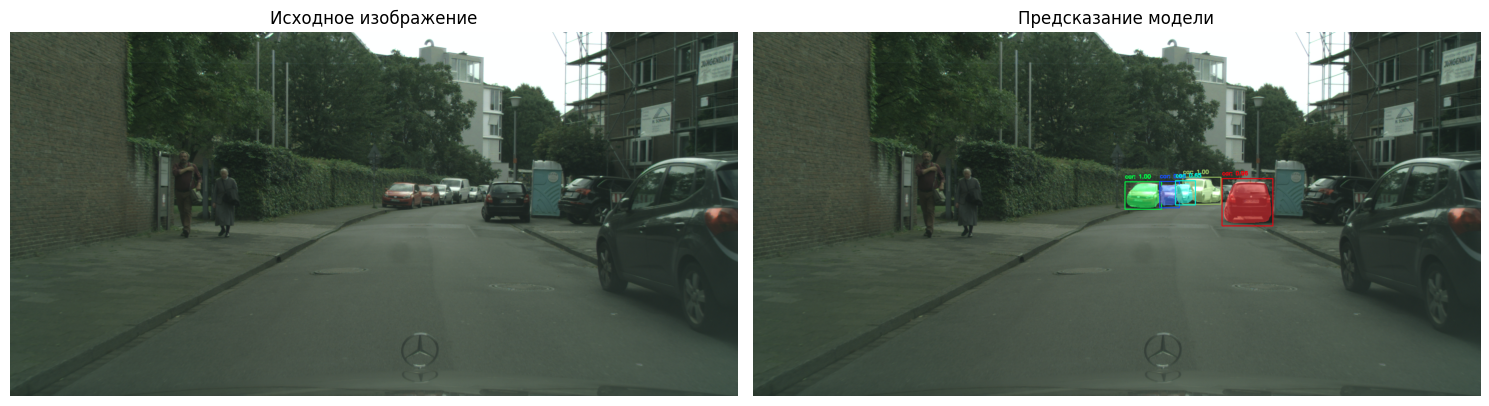


Изображение 73:
Средний IoU: 0.8200
Средняя точность: 0.9183
Средняя полнота: 0.8923
F1-мера: 0.9051


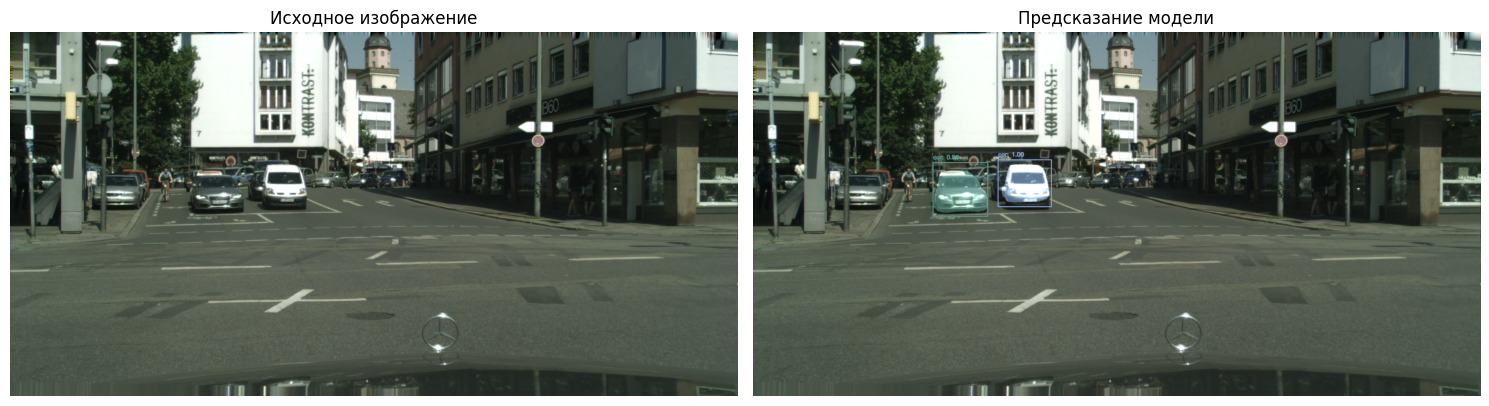


Изображение 374:
Средний IoU: 0.7100
Средняя точность: 0.9656
Средняя полнота: 0.7306
F1-мера: 0.8319


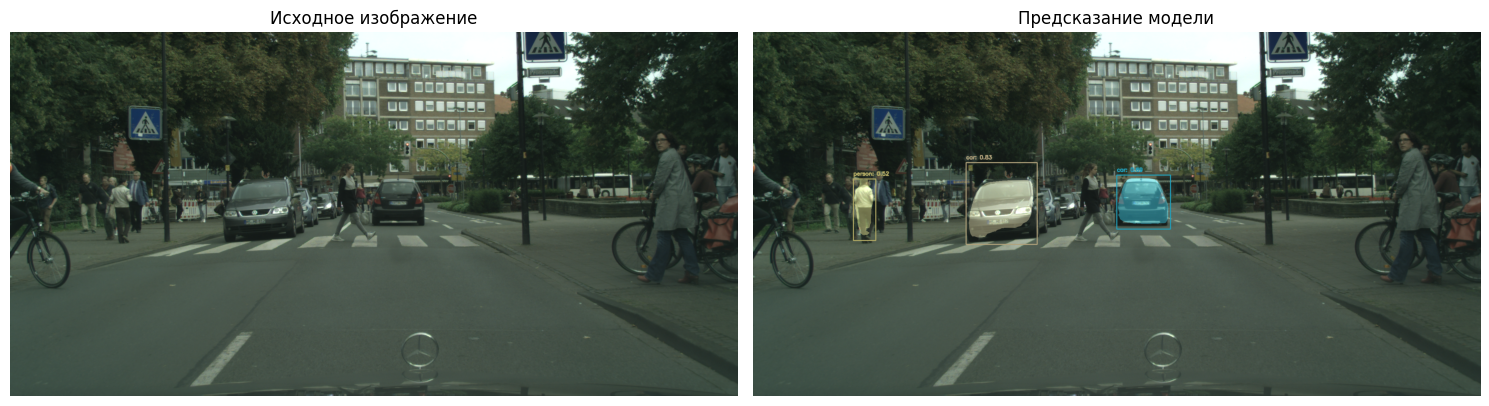


Изображение 155:
Средний IoU: 0.1747
Средняя точность: 0.2500
Средняя полнота: 0.1747
F1-мера: 0.2057


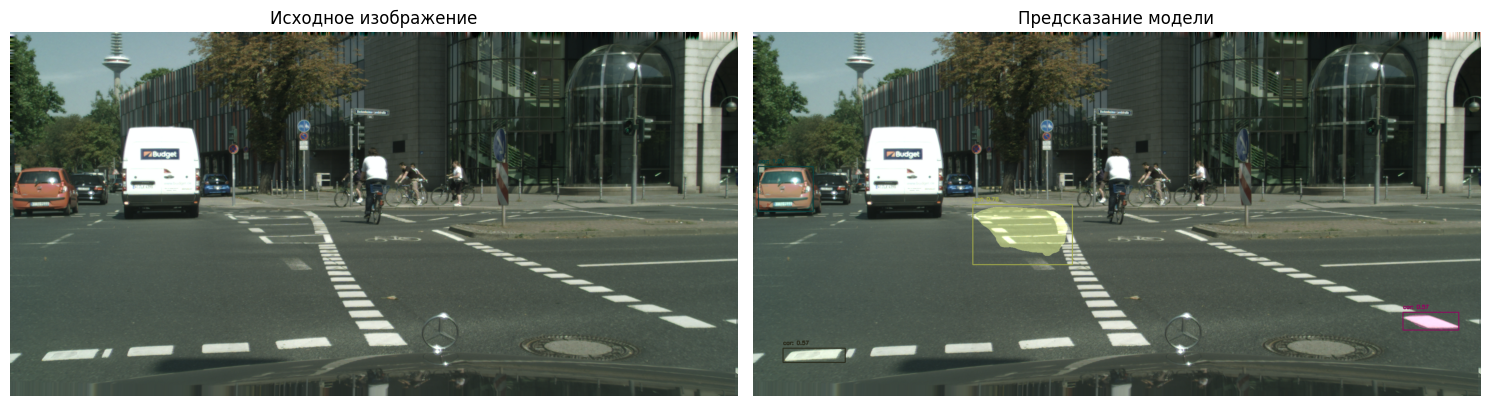


Изображение 104:
Нет совпадений между предсказаниями и ground truth масками.


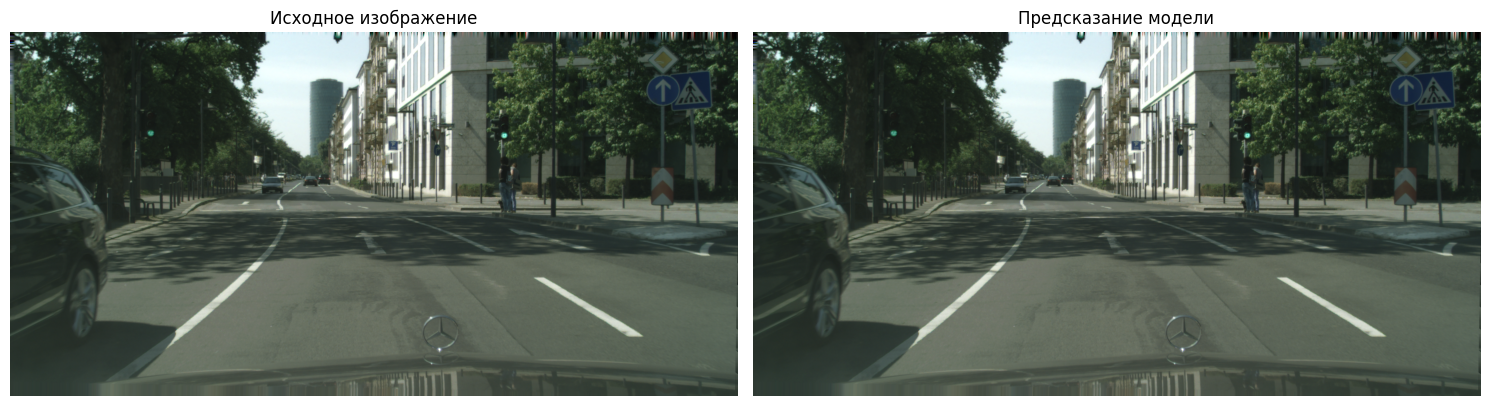

In [15]:
def visualize_prediction(image, prediction, gt_masks=None, confidence_threshold=0.5, mask_threshold=0.5):
    """
    Визуализация предсказаний модели и сравнение с ground truth
    
    Args:
        image: Тензор изображения
        prediction: Предсказание модели (боксы, маски, метки и т.д.)
        gt_masks: Список масок из ground truth аннотаций
        confidence_threshold: Порог уверенности для фильтрации предсказаний
        mask_threshold: Порог для преобразования вероятностных масок в бинарные
    """
    # Преобразование тензора в изображение
    img = image.cpu().permute(1, 2, 0).numpy()
    # Денормализация изображения
    img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
    img = img.astype(np.uint8)
    
    # Создание копии для отображения результатов
    img_with_boxes = img.copy()
    
    # Получение предсказаний с порогом уверенности
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    masks = prediction['masks'].cpu().numpy()
    
    # Фильтрация по порогу уверенности
    keep = scores >= confidence_threshold
    boxes = boxes[keep]
    labels = labels[keep]
    scores = scores[keep]
    masks = masks[keep]
    
    # Отображение bounding boxes и классов
    for i, (box, label, score, mask) in enumerate(zip(boxes, labels, scores, masks)):
        # Преобразование вероятностной маски в бинарную
        binary_mask = (mask[0] > mask_threshold).astype(np.uint8)
        
        # Цвет для текущего объекта (RGB)
        color = np.random.randint(0, 255, size=3).tolist()
        
        # Отображение bounding box
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 2)
        
        # Отображение метки класса и score
        class_name = COCO_INSTANCE_CATEGORY_NAMES[label]
        cv2.putText(img_with_boxes, f'{class_name}: {score:.2f}', 
                    (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Применение маски (смешивание с изображением)
        colored_mask = np.zeros_like(img)
        for c in range(3):
            colored_mask[:, :, c] = binary_mask * color[c]
        
        # Наложение маски с полупрозрачностью
        mask_overlay = cv2.addWeighted(img, 1, colored_mask, 0.5, 0)
        
        # Только в областях маски
        img_with_boxes = np.where(binary_mask[:, :, np.newaxis] > 0, mask_overlay, img_with_boxes)
    
    # Визуализация результатов
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.title('Исходное изображение')
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Предсказание модели')
    plt.imshow(img_with_boxes)
    plt.axis('off')
    
    # Если есть ground truth маски, рассчитываем метрики
    if gt_masks is not None and len(gt_masks) > 0:
        all_ious = []
        all_precisions = []
        all_recalls = []
        
        for pred_mask in masks:
            binary_pred_mask = (pred_mask[0] > mask_threshold).astype(np.uint8)
            
            # Находим лучшую совпадающую gt маску для каждого предсказания
            best_iou = 0
            best_precision = 0
            best_recall = 0
            
            for gt_mask in gt_masks:
                # Изменение размера gt_mask для соответствия размеру предсказания
                resized_gt_mask = cv2.resize(gt_mask, (binary_pred_mask.shape[1], binary_pred_mask.shape[0]), 
                                            interpolation=cv2.INTER_NEAREST)
                
                iou = calculate_iou(binary_pred_mask, resized_gt_mask)
                precision, recall = calculate_precision_recall(binary_pred_mask, resized_gt_mask)
                
                if iou > best_iou:
                    best_iou = iou
                    best_precision = precision
                    best_recall = recall
            
            all_ious.append(best_iou)
            all_precisions.append(best_precision)
            all_recalls.append(best_recall)
        
        # Вывод средних метрик
        if all_ious:
            print(f"Средний IoU: {np.mean(all_ious):.4f}")
            print(f"Средняя точность: {np.mean(all_precisions):.4f}")
            print(f"Средняя полнота: {np.mean(all_recalls):.4f}")
            print(f"F1-мера: {2 * np.mean(all_precisions) * np.mean(all_recalls) / (np.mean(all_precisions) + np.mean(all_recalls) + 1e-10):.4f}")
        else:
            print("Нет совпадений между предсказаниями и ground truth масками.")
    
    plt.tight_layout()
    plt.show()

# Пример использования функции для оценки
results = []

for idx in tqdm(test_indices[:5]):  # Ограничиваем 5 изображениями для примера
    img, target = test_dataset[idx]
    
    # Получение предсказания для текущего изображения
    prediction = get_prediction(img)
    
    # Получение ground truth масок из аннотации
    gt_masks = get_mask_from_cityscapes(target)
    
    # Визуализация и расчет метрик
    print(f"\nИзображение {idx}:")
    visualize_prediction(img, prediction, gt_masks, confidence_threshold=0.5, mask_threshold=0.5)
    
    # Сохранение результатов для дальнейшего анализа
    masks = prediction['masks'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    # Фильтрация по порогу уверенности
    keep = scores >= 0.5
    filtered_masks = masks[keep]
    
    # Расчет метрик для каждой предсказанной маски
    for i, mask in enumerate(filtered_masks):
        binary_mask = (mask[0] > 0.5).astype(np.uint8)
        best_iou = 0
        
        for gt_mask in gt_masks:
            # Изменение размера gt_mask для соответствия размеру предсказания
            resized_gt_mask = cv2.resize(gt_mask, (binary_mask.shape[1], binary_mask.shape[0]), 
                                          interpolation=cv2.INTER_NEAREST)
            
            iou = calculate_iou(binary_mask, resized_gt_mask)
            if iou > best_iou:
                best_iou = iou
        
        results.append({
            'image_idx': idx,
            'mask_idx': i,
            'iou': best_iou,
            'score': scores[keep][i]
        })

#### 2.6 Исследование параметров маски и confidence

Проведите серию экспериментов: протестируйте разные значения mask_threshold (0.3, 0.5, 0.7), протестируйте разные значения confidence_threshold, найдите оптимальное значение, при котором достигается лучший баланс между точностью и полнотой:



Тестирование: mask_threshold=0.3, confidence_threshold=0.3


  0%|          | 0/20 [00:00<?, ?it/s]

Среднее IoU: 0.4119
Средняя точность: 0.5961
Средняя полнота: 0.4823
F1-мера: 0.5332
Количество предсказаний: 56

Тестирование: mask_threshold=0.3, confidence_threshold=0.5


  0%|          | 0/20 [00:00<?, ?it/s]

Среднее IoU: 0.4779
Средняя точность: 0.6836
Средняя полнота: 0.5503
F1-мера: 0.6098
Количество предсказаний: 42

Тестирование: mask_threshold=0.3, confidence_threshold=0.7


  0%|          | 0/20 [00:00<?, ?it/s]

Среднее IoU: 0.5297
Средняя точность: 0.7232
Средняя полнота: 0.6158
F1-мера: 0.6652
Количество предсказаний: 25

Тестирование: mask_threshold=0.3, confidence_threshold=0.9


  0%|          | 0/20 [00:00<?, ?it/s]

Среднее IoU: 0.6040
Средняя точность: 0.7616
Средняя полнота: 0.6912
F1-мера: 0.7247
Количество предсказаний: 15

Тестирование: mask_threshold=0.5, confidence_threshold=0.3


  0%|          | 0/20 [00:00<?, ?it/s]

Среднее IoU: 0.3884
Средняя точность: 0.6209
Средняя полнота: 0.4335
F1-мера: 0.5106
Количество предсказаний: 56

Тестирование: mask_threshold=0.5, confidence_threshold=0.5


  0%|          | 0/20 [00:00<?, ?it/s]

Среднее IoU: 0.4497
Средняя точность: 0.7106
Средняя полнота: 0.4958
F1-мера: 0.5841
Количество предсказаний: 42

Тестирование: mask_threshold=0.5, confidence_threshold=0.7


  0%|          | 0/20 [00:00<?, ?it/s]

Среднее IoU: 0.5067
Средняя точность: 0.7551
Средняя полнота: 0.5618
F1-мера: 0.6443
Количество предсказаний: 25

Тестирование: mask_threshold=0.5, confidence_threshold=0.9


  0%|          | 0/20 [00:00<?, ?it/s]

Среднее IoU: 0.5886
Средняя точность: 0.7968
Средняя полнота: 0.6415
F1-мера: 0.7108
Количество предсказаний: 15

Тестирование: mask_threshold=0.7, confidence_threshold=0.3


  0%|          | 0/20 [00:00<?, ?it/s]

Среднее IoU: 0.3495
Средняя точность: 0.6420
Средняя полнота: 0.3747
F1-мера: 0.4732
Количество предсказаний: 56

Тестирование: mask_threshold=0.7, confidence_threshold=0.5


  0%|          | 0/20 [00:00<?, ?it/s]

Среднее IoU: 0.4044
Средняя точность: 0.7328
Средняя полнота: 0.4301
F1-мера: 0.5421
Количество предсказаний: 42

Тестирование: mask_threshold=0.7, confidence_threshold=0.7


  0%|          | 0/20 [00:00<?, ?it/s]

Среднее IoU: 0.4645
Средняя точность: 0.7810
Средняя полнота: 0.4953
F1-мера: 0.6062
Количество предсказаний: 25

Тестирование: mask_threshold=0.7, confidence_threshold=0.9


  0%|          | 0/20 [00:00<?, ?it/s]

Среднее IoU: 0.5489
Средняя точность: 0.8247
Средняя полнота: 0.5765
F1-мера: 0.6786
Количество предсказаний: 15


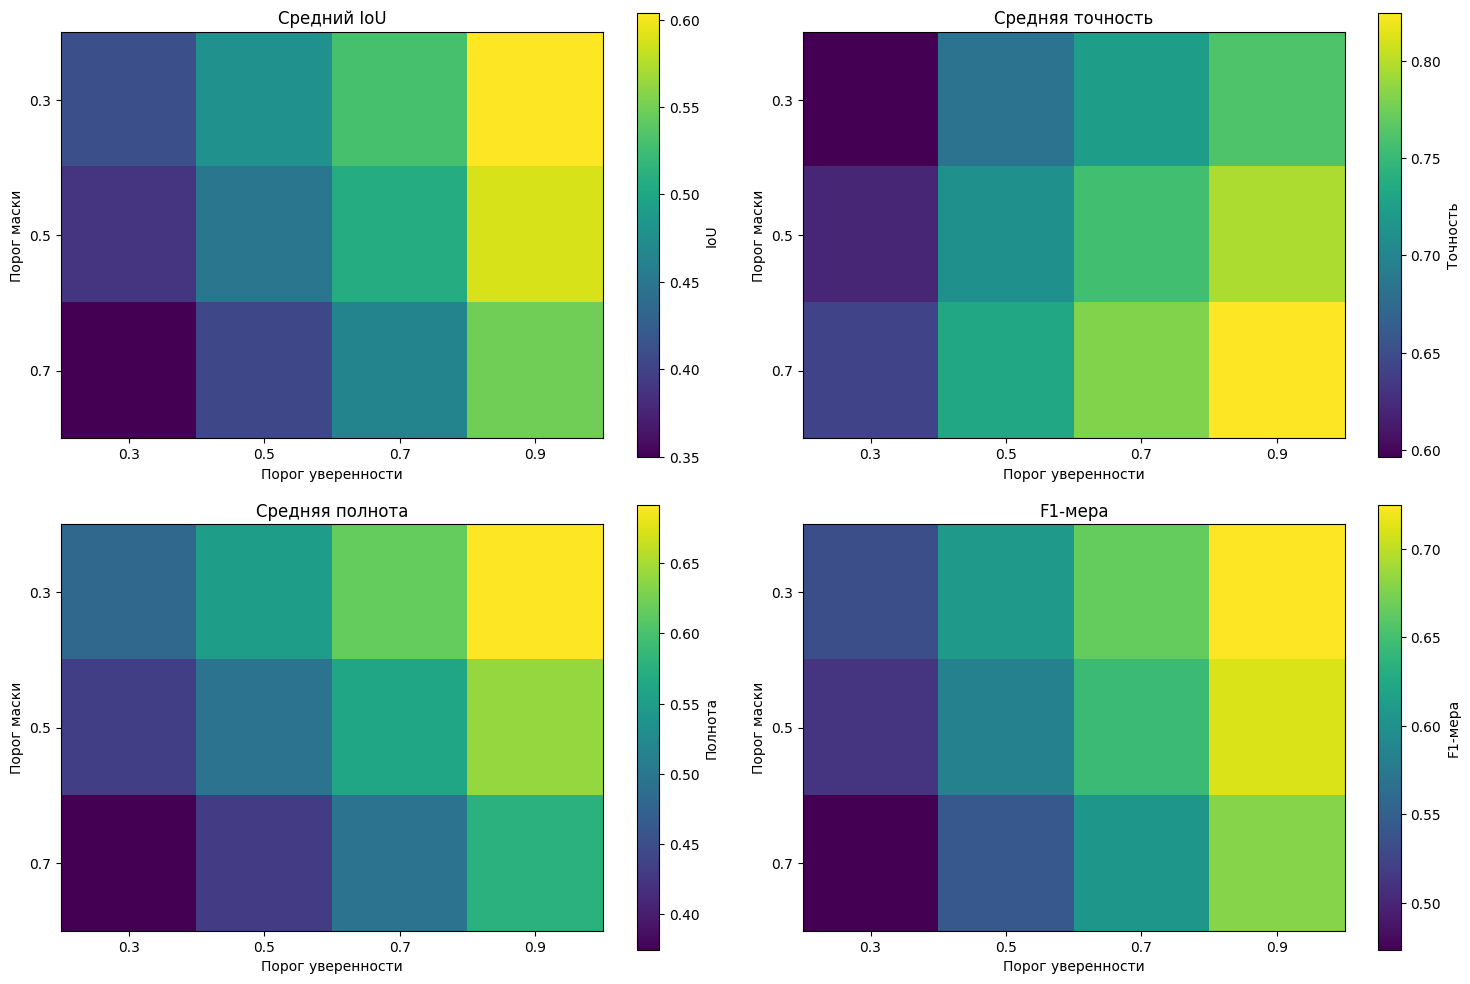


Оптимальные параметры:
Порог маски: 0.3
Порог уверенности: 0.9
F1-мера: 0.7247


In [16]:
def evaluate_thresholds(test_indices, mask_thresholds=[0.3, 0.5, 0.7], confidence_thresholds=[0.3, 0.5, 0.7, 0.9]):
    """
    Исследование влияния пороговых значений на качество предсказаний
    
    Args:
        test_indices: Индексы тестовых изображений
        mask_thresholds: Список пороговых значений для масок
        confidence_thresholds: Список пороговых значений для уверенности
    """
    # Словарь для хранения результатов
    results = {}
    
    for mask_threshold in mask_thresholds:
        results[mask_threshold] = {}
        
        for confidence_threshold in confidence_thresholds:
            print(f"\nТестирование: mask_threshold={mask_threshold}, confidence_threshold={confidence_threshold}")
            
            all_ious = []
            all_precisions = []
            all_recalls = []
            num_predictions = 0
            
            for idx in tqdm(test_indices[:20]):  # Все 20 изображений
                img, target = test_dataset[idx]
                
                # Получение предсказания
                prediction = get_prediction(img)
                
                # Получение ground truth масок
                gt_masks = get_mask_from_cityscapes(target)
                
                # Извлечение предсказаний
                boxes = prediction['boxes'].cpu().numpy()
                scores = prediction['scores'].cpu().numpy()
                masks = prediction['masks'].cpu().numpy()
                
                # Фильтрация по порогу уверенности
                keep = scores >= confidence_threshold
                filtered_masks = masks[keep]
                
                num_predictions += len(filtered_masks)
                
                # Расчет метрик для каждой предсказанной маски
                for mask in filtered_masks:
                    binary_mask = (mask[0] > mask_threshold).astype(np.uint8)
                    
                    # Находим лучшую совпадающую gt маску
                    best_iou = 0
                    best_precision = 0
                    best_recall = 0
                    
                    for gt_mask in gt_masks:
                        # Изменение размера gt_mask
                        resized_gt_mask = cv2.resize(gt_mask, (binary_mask.shape[1], binary_mask.shape[0]), 
                                                    interpolation=cv2.INTER_NEAREST)
                        
                        iou = calculate_iou(binary_mask, resized_gt_mask)
                        precision, recall = calculate_precision_recall(binary_mask, resized_gt_mask)
                        
                        if iou > best_iou:
                            best_iou = iou
                            best_precision = precision
                            best_recall = recall
                    
                    all_ious.append(best_iou)
                    all_precisions.append(best_precision)
                    all_recalls.append(best_recall)
            
            # Расчет средних метрик
            mean_iou = np.mean(all_ious) if all_ious else 0
            mean_precision = np.mean(all_precisions) if all_precisions else 0
            mean_recall = np.mean(all_recalls) if all_recalls else 0
            f1_score = 2 * mean_precision * mean_recall / (mean_precision + mean_recall + 1e-10) if (mean_precision + mean_recall) > 0 else 0
            
            # Сохранение результатов
            results[mask_threshold][confidence_threshold] = {
                'mean_iou': mean_iou,
                'mean_precision': mean_precision,
                'mean_recall': mean_recall,
                'f1_score': f1_score,
                'num_predictions': num_predictions
            }
            
            print(f"Среднее IoU: {mean_iou:.4f}")
            print(f"Средняя точность: {mean_precision:.4f}")
            print(f"Средняя полнота: {mean_recall:.4f}")
            print(f"F1-мера: {f1_score:.4f}")
            print(f"Количество предсказаний: {num_predictions}")
    
    # Визуализация результатов в виде тепловых карт
    plt.figure(figsize=(15, 10))
    
    # Тепловая карта для IoU
    plt.subplot(2, 2, 1)
    iou_heatmap = np.zeros((len(mask_thresholds), len(confidence_thresholds)))
    for i, mask_threshold in enumerate(mask_thresholds):
        for j, confidence_threshold in enumerate(confidence_thresholds):
            iou_heatmap[i, j] = results[mask_threshold][confidence_threshold]['mean_iou']
    
    plt.imshow(iou_heatmap, cmap='viridis')
    plt.colorbar(label='IoU')
    plt.title('Средний IoU')
    plt.xlabel('Порог уверенности')
    plt.ylabel('Порог маски')
    plt.xticks(np.arange(len(confidence_thresholds)), confidence_thresholds)
    plt.yticks(np.arange(len(mask_thresholds)), mask_thresholds)
    
    # Тепловая карта для точности
    plt.subplot(2, 2, 2)
    precision_heatmap = np.zeros((len(mask_thresholds), len(confidence_thresholds)))
    for i, mask_threshold in enumerate(mask_thresholds):
        for j, confidence_threshold in enumerate(confidence_thresholds):
            precision_heatmap[i, j] = results[mask_threshold][confidence_threshold]['mean_precision']
    
    plt.imshow(precision_heatmap, cmap='viridis')
    plt.colorbar(label='Точность')
    plt.title('Средняя точность')
    plt.xlabel('Порог уверенности')
    plt.ylabel('Порог маски')
    plt.xticks(np.arange(len(confidence_thresholds)), confidence_thresholds)
    plt.yticks(np.arange(len(mask_thresholds)), mask_thresholds)
    
    # Тепловая карта для полноты
    plt.subplot(2, 2, 3)
    recall_heatmap = np.zeros((len(mask_thresholds), len(confidence_thresholds)))
    for i, mask_threshold in enumerate(mask_thresholds):
        for j, confidence_threshold in enumerate(confidence_thresholds):
            recall_heatmap[i, j] = results[mask_threshold][confidence_threshold]['mean_recall']
    
    plt.imshow(recall_heatmap, cmap='viridis')
    plt.colorbar(label='Полнота')
    plt.title('Средняя полнота')
    plt.xlabel('Порог уверенности')
    plt.ylabel('Порог маски')
    plt.xticks(np.arange(len(confidence_thresholds)), confidence_thresholds)
    plt.yticks(np.arange(len(mask_thresholds)), mask_thresholds)
    
    # Тепловая карта для F1-меры
    plt.subplot(2, 2, 4)
    f1_heatmap = np.zeros((len(mask_thresholds), len(confidence_thresholds)))
    for i, mask_threshold in enumerate(mask_thresholds):
        for j, confidence_threshold in enumerate(confidence_thresholds):
            f1_heatmap[i, j] = results[mask_threshold][confidence_threshold]['f1_score']
    
    plt.imshow(f1_heatmap, cmap='viridis')
    plt.colorbar(label='F1-мера')
    plt.title('F1-мера')
    plt.xlabel('Порог уверенности')
    plt.ylabel('Порог маски')
    plt.xticks(np.arange(len(confidence_thresholds)), confidence_thresholds)
    plt.yticks(np.arange(len(mask_thresholds)), mask_thresholds)
    
    plt.tight_layout()
    plt.show()
    
    # Определение оптимальных параметров
    best_f1 = 0
    best_params = None
    
    for mask_threshold in mask_thresholds:
        for confidence_threshold in confidence_thresholds:
            f1 = results[mask_threshold][confidence_threshold]['f1_score']
            if f1 > best_f1:
                best_f1 = f1
                best_params = (mask_threshold, confidence_threshold)
    
    print(f"\nОптимальные параметры:")
    print(f"Порог маски: {best_params[0]}")
    print(f"Порог уверенности: {best_params[1]}")
    print(f"F1-мера: {best_f1:.4f}")

# Запуск исследования
evaluate_thresholds(test_indices)